In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Dataset loading and first analysis

In [2]:
df = pd.read_csv('pizza_v1.csv')
df.head()

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
0,A,"Rp235,000",22.0,chicken,double_signature,jumbo,yes,yes
1,A,"Rp198,000",20.0,papperoni,double_signature,jumbo,yes,yes
2,A,"Rp120,000",16.0,mushrooms,double_signature,reguler,yes,yes
3,A,"Rp155,000",14.0,smoked beef,double_signature,reguler,yes,no
4,A,"Rp248,000",18.0,mozzarella,double_signature,jumbo,yes,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       129 non-null    object 
 1   price_rupiah  129 non-null    object 
 2   diameter      129 non-null    float64
 3   topping       129 non-null    object 
 4   variant       129 non-null    object 
 5   size          129 non-null    object 
 6   extra_sauce   129 non-null    object 
 7   extra_cheese  129 non-null    object 
dtypes: float64(1), object(7)
memory usage: 8.2+ KB


In [10]:
# remove "Rp" and comma from "price_rupiah" column 
df['price_rupiah'] = df['price_rupiah'].str.replace('Rp','').str.replace(",",'')
df['price_rupiah'] = df['price_rupiah'].astype(int)

In [11]:
df.head()

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
0,A,235000,22.0,chicken,double_signature,jumbo,yes,yes
1,A,198000,20.0,papperoni,double_signature,jumbo,yes,yes
2,A,120000,16.0,mushrooms,double_signature,reguler,yes,yes
3,A,155000,14.0,smoked beef,double_signature,reguler,yes,no
4,A,248000,18.0,mozzarella,double_signature,jumbo,yes,no


In [9]:
# Number of unique values on object datatypes
df.select_dtypes(include='object').nunique()
 

company          5
price_rupiah    43
topping         12
variant         20
size             6
extra_sauce      2
extra_cheese     2
dtype: int64

# Segment Pizza Variant

In [12]:
df.variant.unique()

array(['double_signature', 'american_favorite', 'super_supreme',
       'meat_lovers', 'double_mix', 'classic', 'crunchy', 'new_york',
       'double_decker', 'spicy_tuna', 'BBQ_meat_fiesta', 'BBQ_sausage',
       'extravaganza', 'meat_eater', 'gournet_greek', 'italian_veggie',
       'thai_veggie', 'american_classic', 'neptune_tuna', 'spicy tuna'],
      dtype=object)

In [13]:
# define function to segment pizza names into types

def segment_variant(variant):
    if 'veggie' in variant:
        return 'Vegetarian'
    elif 'meat' in variant or 'BBQ' in variant:
        return 'Meat'
    elif "tuna" in variant:
        return 'Seafood'
    else:
        return 'Others'

In [15]:
df['variant']=df['variant'].apply(segment_variant)

<AxesSubplot:>

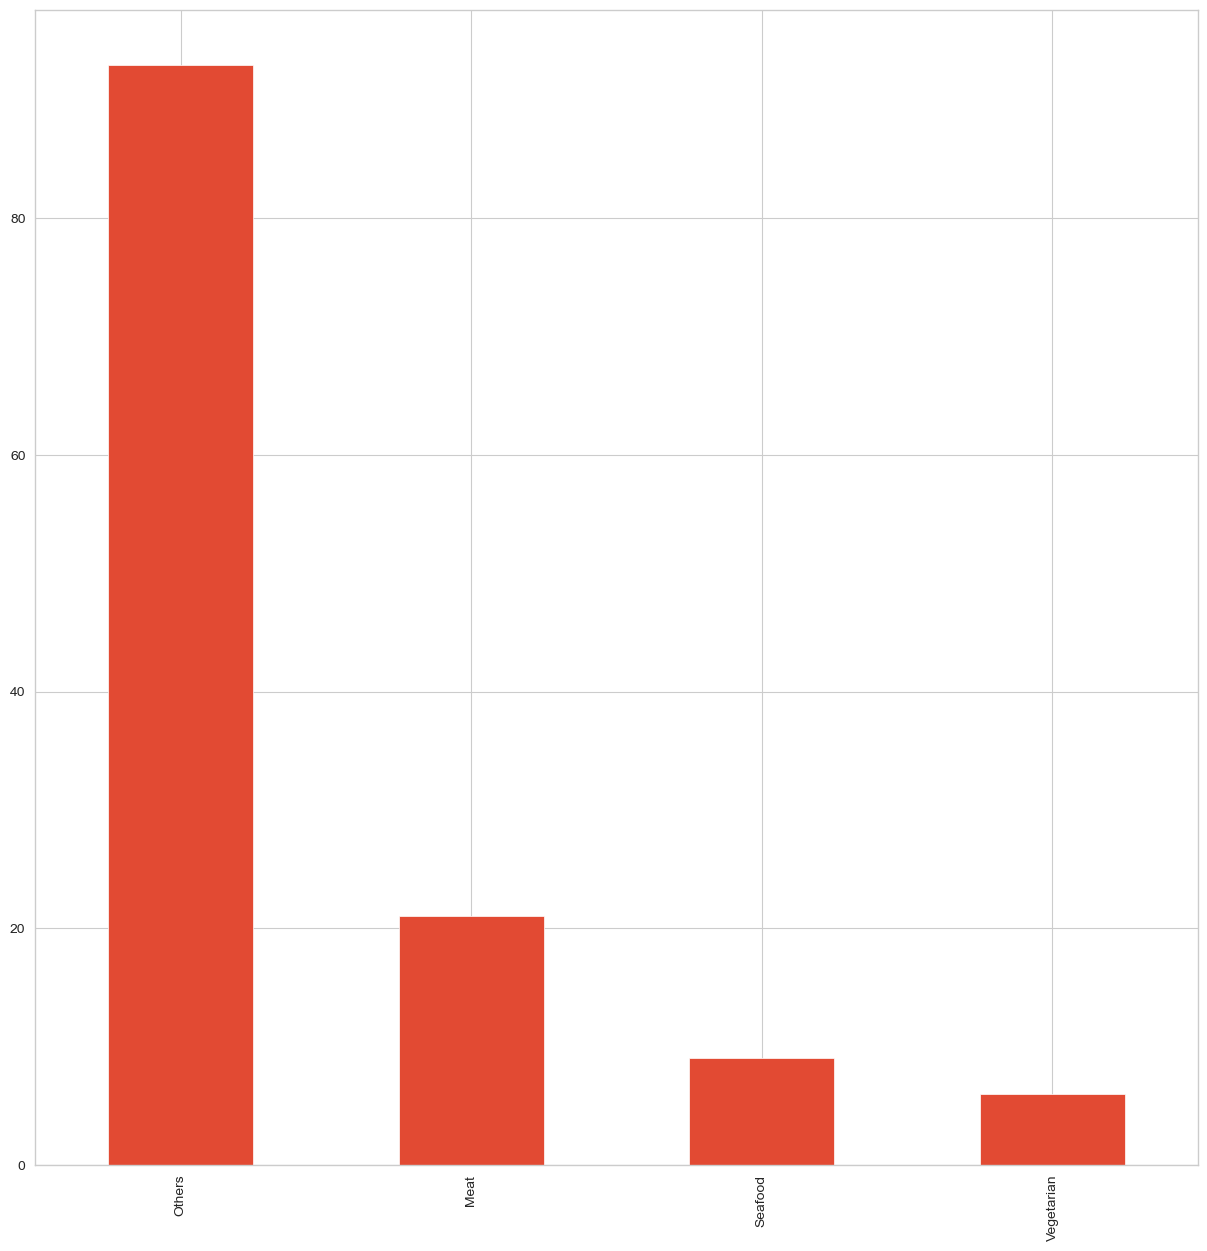

In [16]:
plt.figure(figsize=(15,15))
df['variant'].value_counts().plot(kind='bar')

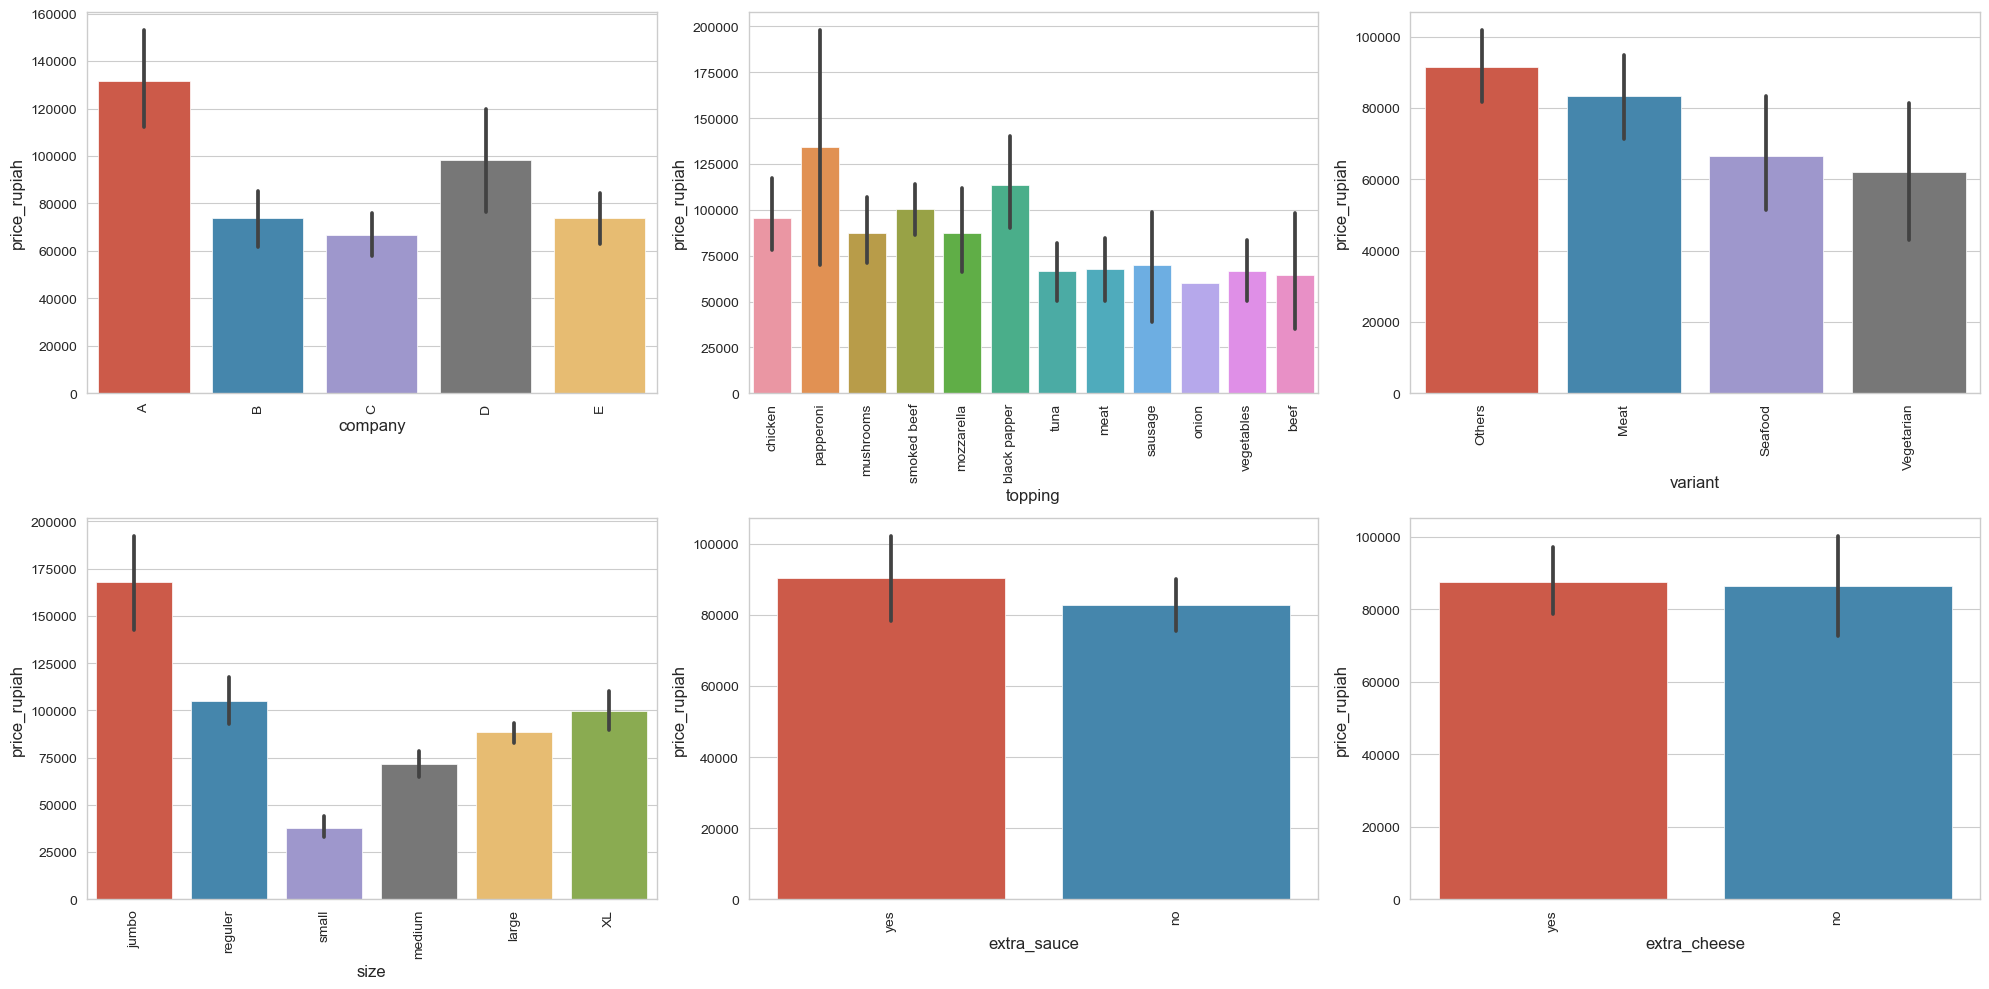

In [23]:
 # list of categorical variables to plot
cat_vars = ['company', 'topping', 'variant', 'size', 'extra_sauce', 'extra_cheese']

# create figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axs = axs.ravel()

# create barplot for each categorical variable
for i, var in enumerate(cat_vars):
    sns.barplot(x=var, y='price_rupiah', data=df, ax=axs[i], estimator=np.mean)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# adjust spacing between subplots
fig.tight_layout()

# show plot
plt.show()

<AxesSubplot:xlabel='diameter'>

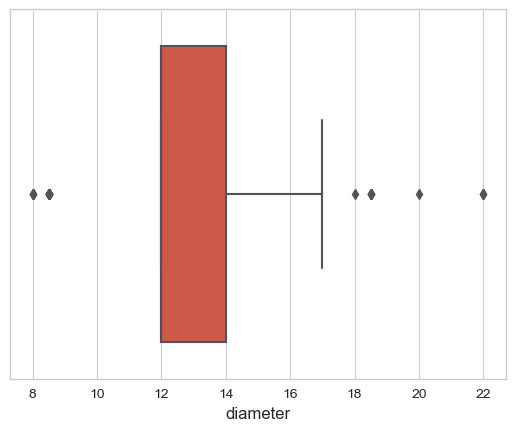

In [18]:
sns.boxplot(x='diameter', data=df)

<AxesSubplot:xlabel='diameter'>

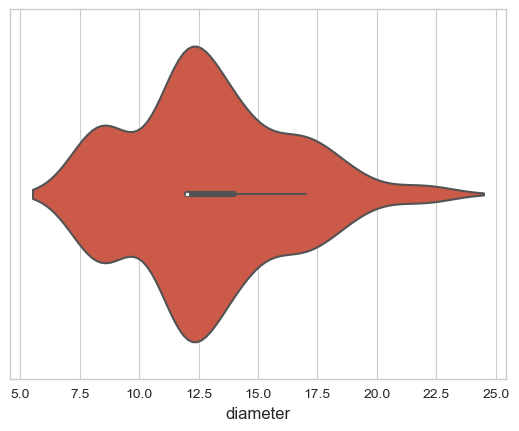

In [20]:
sns.violinplot(x='diameter', data=df)

<AxesSubplot:xlabel='diameter', ylabel='price_rupiah'>

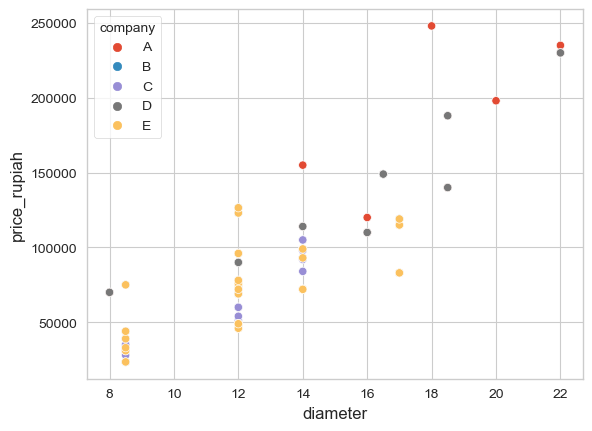

In [21]:
sns.scatterplot(data=df, x="diameter", y="price_rupiah", hue="company")

# Data Preprocessing

In [24]:
#Check missing value
check_missing = df.isnull().sum() * 100 / df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

# Label Encoding

In [25]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:
    
    # Print the column name and the unique values
    print(f"{col}: {df[col].unique()}")

company: ['A' 'B' 'C' 'D' 'E']
topping: ['chicken' 'papperoni' 'mushrooms' 'smoked beef' 'mozzarella'
 'black papper' 'tuna' 'meat' 'sausage' 'onion' 'vegetables' 'beef']
variant: ['Others' 'Meat' 'Seafood' 'Vegetarian']
size: ['jumbo' 'reguler' 'small' 'medium' 'large' 'XL']
extra_sauce: ['yes' 'no']
extra_cheese: ['yes' 'no']


In [26]:
from sklearn import preprocessing

# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:
    
    # Initialize a LabelEncoder object
    label_encoder = preprocessing.LabelEncoder()
    
    # Fit the encoder to the unique values in the column
    label_encoder.fit(df[col].unique())
    
    # Transform the column using the encoder
    df[col] = label_encoder.transform(df[col])
    
    # Print the column name and the unique encoded values
    print(f"{col}: {df[col].unique()}")

company: [0 1 2 3 4]
topping: [ 2  7  5  9  4  1 10  3  8  6 11  0]
variant: [1 0 2 3]
size: [1 4 5 3 2 0]
extra_sauce: [1 0]
extra_cheese: [1 0]


<AxesSubplot:>

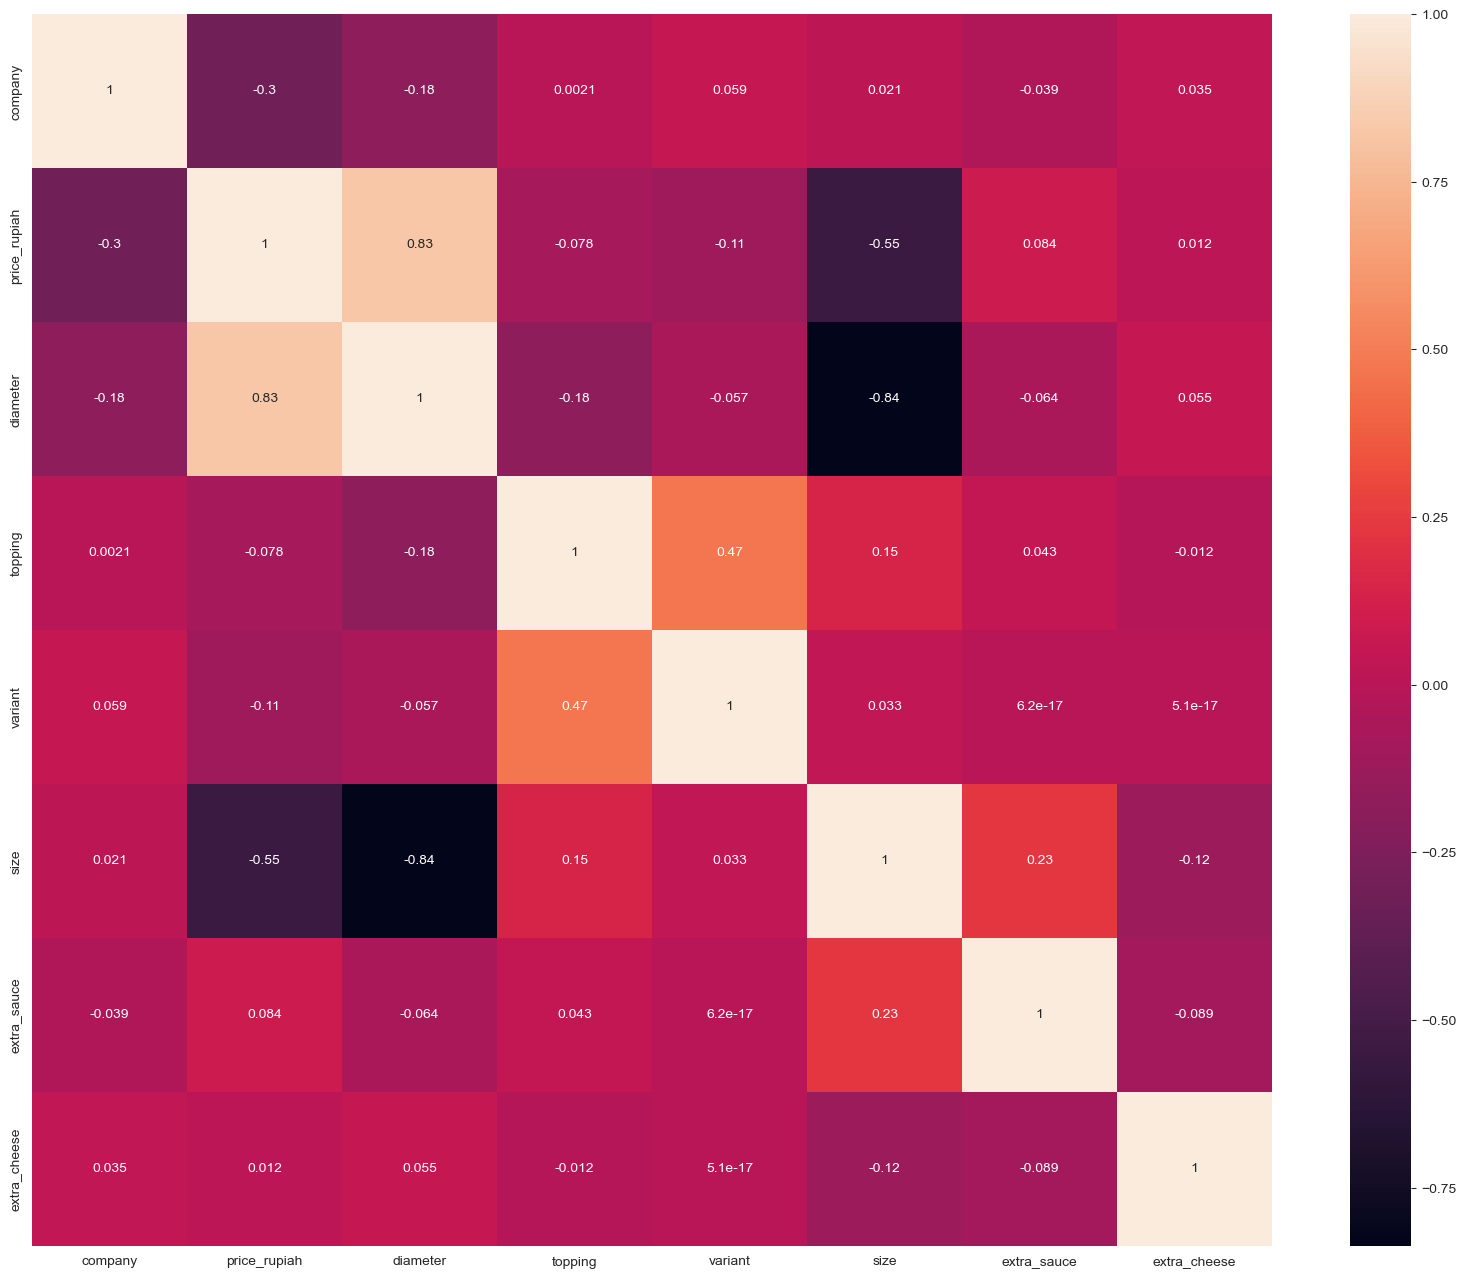

In [27]:
#Correlation Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), fmt='.2g', annot=True)

# Train Test Split

In [28]:
X = df.drop('price_rupiah', axis=1)
y = df['price_rupiah']

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

# Decision Tree Regressor

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston


# Create a DecisionTreeRegressor object
dtree = DecisionTreeRegressor()

# Define the hyperparameters to tune and their values
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6}


In [31]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=0, max_depth=8, max_features='auto', min_samples_leaf=1, min_samples_split=2)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, max_features='auto', random_state=0)

In [32]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import math
y_pred = dtree.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

print('MAE is {}'.format(mae))
print('MAPE is {}'.format(mape))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print('RMSE score is {}'.format(rmse))

MAE is 8896.153846153846
MAPE is 0.11478195348575036
MSE is 173730965.46310833
R2 score is 0.7989720567793299
RMSE score is 13180.704285549704


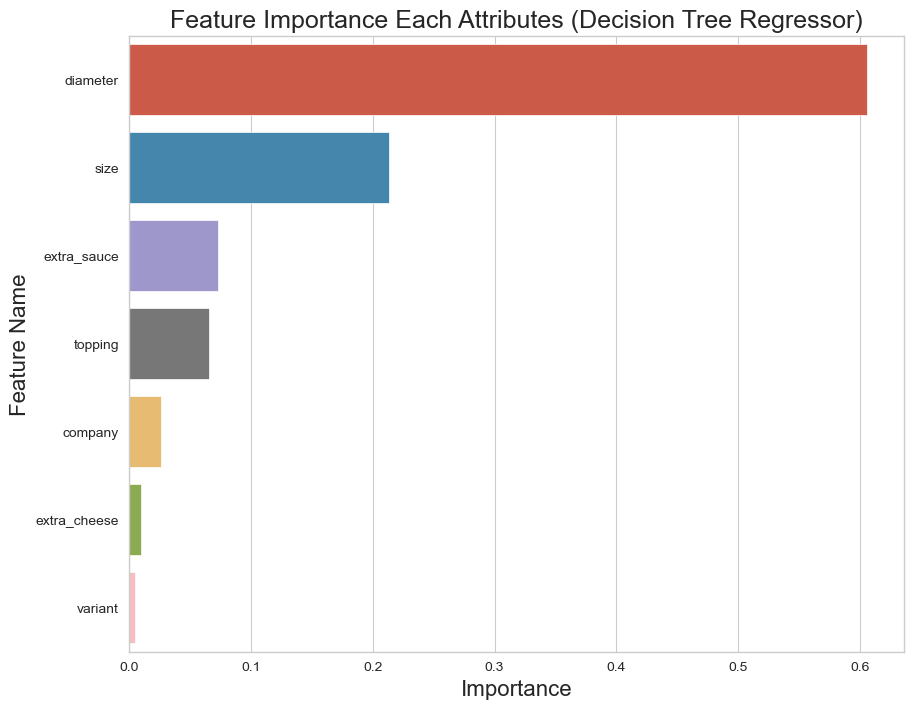

In [33]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Decision Tree Regressor)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

# Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create a Random Forest Regressor object
rf = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [35]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0, max_depth=9, min_samples_split=2, min_samples_leaf=1, 
                           max_features='auto')
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, random_state=0)

In [36]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import math
y_pred = rf.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

print('MAE is {}'.format(mae))
print('MAPE is {}'.format(mape))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print('RMSE score is {}'.format(rmse))

MAE is 10979.558705183706
MAPE is 0.16435802453302076
MSE is 174617535.78390014
R2 score is 0.7979461866494185
RMSE score is 13214.292859774985


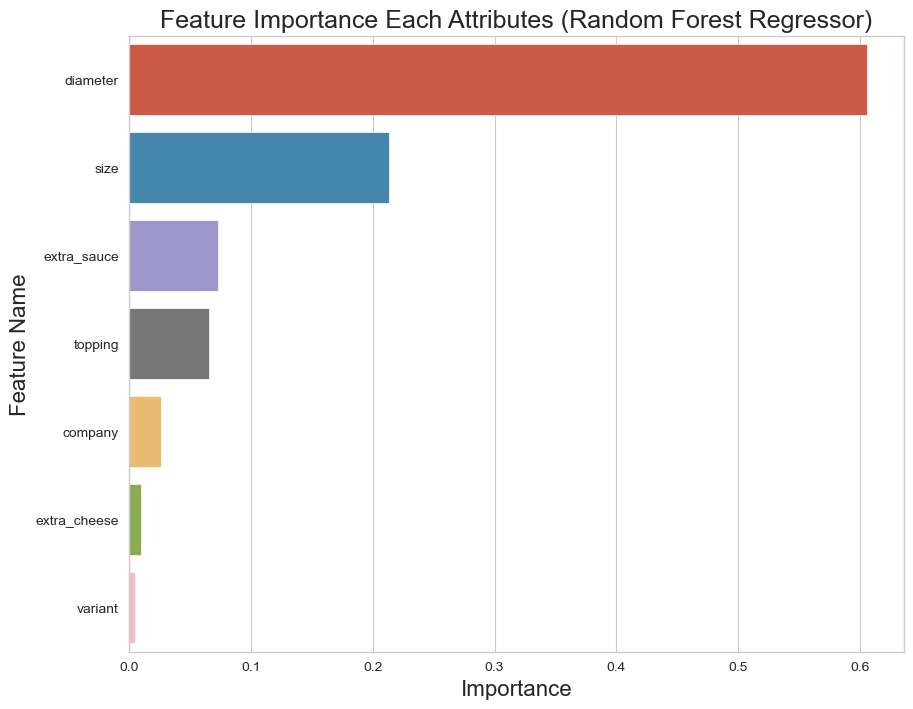

In [37]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Random Forest Regressor)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

# AdaBoost Regressor

In [38]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Define AdaBoostRegressor model
abr = AdaBoostRegressor()

# Define hyperparameters and possible values
params = {'n_estimators': [50, 100, 150],
          'learning_rate': [0.01, 0.1, 1, 10]}

# Perform GridSearchCV with 5-fold cross validation
grid_search = GridSearchCV(abr, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'learning_rate': 0.1, 'n_estimators': 50}


In [39]:
from sklearn.ensemble import RandomForestRegressor
abr = AdaBoostRegressor(random_state=0, learning_rate=1, n_estimators=50)
abr.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=1, random_state=0)

In [40]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import math
y_pred = abr.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

print('MAE is {}'.format(mae))
print('MAPE is {}'.format(mape))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print('RMSE score is {}'.format(rmse))

MAE is 11310.953520583891
MAPE is 0.18546632912903405
MSE is 213998142.11136267
R2 score is 0.752378015933912
RMSE score is 14628.675336863645


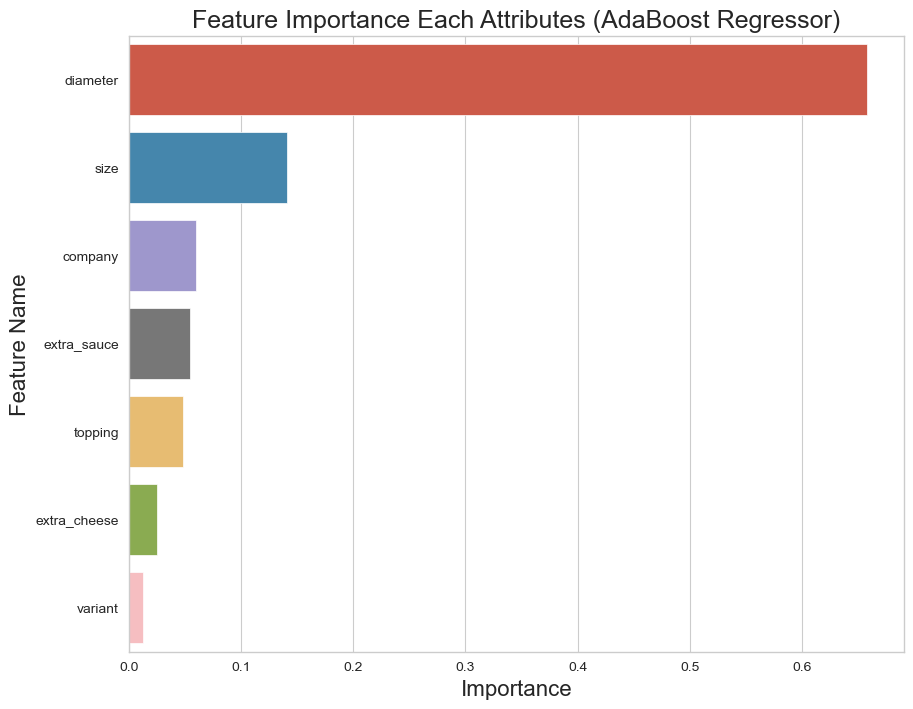

In [41]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": abr.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (AdaBoost Regressor)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()